# Hierarchical Nested Lattice Quantization Demo

This notebook demonstrates hierarchical nested lattice quantization using the D4 lattice, showing how multi-level quantization can improve rate-distortion performance.

In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.lattices.quantizers.nested_lattice_quantizer import NestedLatticeQuantizer
from src.lattices.utils import get_d4, closest_point_Dn, SIG_D4

## Setup Hierarchical D4 Lattice Quantizers

We'll create multiple nested lattice quantizers with different parameters for hierarchical quantization. Each level will have a different scaling factor (beta) to create a nested structure.

In [2]:
# D4 lattice parameters
d = 4  # Dimension
G = get_d4()  # Generator matrix for D4 lattice
Q_nn = lambda x: closest_point_Dn(x)  # D4 lattice closest point algorithm

# Create hierarchical quantizers with different scales
M = 3  # Number of hierarchical levels
hierarchical_betas = [SIG_D4 * (2**i) for i in range(M)]  # Different scales for each level
quantizers = []

for beta in hierarchical_betas:
    quantizer = NestedLatticeQuantizer(
        G=G,
        Q_nn=Q_nn,
        q=4,  # Quantization factor
        beta=beta,  # Different scaling for each level
        alpha=1.0,  # Overload scaling factor
        eps=np.zeros(d),
        dither=np.zeros(d)
    )
    quantizers.append(quantizer)

## Test Hierarchical Quantization

We'll generate test vectors, quantize them at different levels, and compare the reconstruction quality.

In [3]:
# Function to perform hierarchical quantization
def hierarchical_quantize(x, quantizers):
    results = []
    x_current = x.copy()
    accumulated_reconstruction = np.zeros_like(x)
    
    for level, quantizer in enumerate(quantizers):
        # Quantize the residual
        enc, T = quantizer.encode(x_current, with_dither=False)
        x_hat = quantizer.decode(enc, T, with_dither=False)
        
        # Update accumulated reconstruction
        accumulated_reconstruction += x_hat
        
        # Compute residual for next level
        x_current = x - accumulated_reconstruction
        
        # Compute error at this level
        error = np.linalg.norm(x - accumulated_reconstruction)
        
        results.append({
            'Level': level + 1,
            'Encoding': enc,
            'Reconstruction': accumulated_reconstruction.copy(),
            'Error': error
        })
    
    return results

# Generate test samples and apply hierarchical quantization
n_samples = 5
test_scales = [0.5, 1.0, 2.0]
all_results = []

for scale in test_scales:
    for i in range(n_samples):
        # Generate random test vector
        x = np.random.normal(0, scale, size=d)
        
        # Apply hierarchical quantization
        results = hierarchical_quantize(x, quantizers)
        
        for res in results:
            all_results.append({
                'Scale': scale,
                'Sample': i + 1,
                'Level': res['Level'],
                'Original': np.round(x, 3),
                'Reconstructed': np.round(res['Reconstruction'], 3),
                'Error': np.round(res['Error'], 3)
            })

## Display Results

In [4]:
# Create DataFrame and display results
df = pd.DataFrame(all_results)
print("\nHierarchical Quantization Results:")
print("=" * 80)
print(df.to_string(index=False))

# Calculate average error for each level and scale
avg_errors = df.groupby(['Scale', 'Level'])['Error'].mean().unstack()
print("\nAverage Error by Scale and Level:")
print("=" * 40)
print(avg_errors.to_string())


Hierarchical Quantization Results:
 Scale  Sample  Level                         Original                   Reconstructed  Error
   0.5       1      1   [-1.171, 0.318, 0.409, -0.132]    [-1.3, 0.433, 0.433, -0.433]  0.348
   0.5       1      2   [-1.171, 0.318, 0.409, -0.132]  [-1.083, 0.433, 0.433, -0.217]  0.169
   0.5       1      3   [-1.171, 0.318, 0.409, -0.132]  [-1.083, 0.433, 0.433, -0.217]  0.169
   0.5       2      1   [-0.155, -0.036, 0.11, -0.178]    [-0.108, 0.0, 0.108, -0.217]  0.070
   0.5       2      2   [-0.155, -0.036, 0.11, -0.178]    [-0.108, 0.0, 0.108, -0.217]  0.070
   0.5       2      3   [-0.155, -0.036, 0.11, -0.178]    [-0.108, 0.0, 0.108, -0.217]  0.070
   0.5       3      1   [0.606, 0.103, -0.275, -0.494]    [0.867, 0.0, -0.433, -0.433]  0.327
   0.5       3      2   [0.606, 0.103, -0.275, -0.494]     [0.65, 0.0, -0.217, -0.433]  0.140
   0.5       3      3   [0.606, 0.103, -0.275, -0.494]     [0.65, 0.0, -0.217, -0.433]  0.140
   0.5       4      1 [-

## Visualize Rate-Distortion Performance

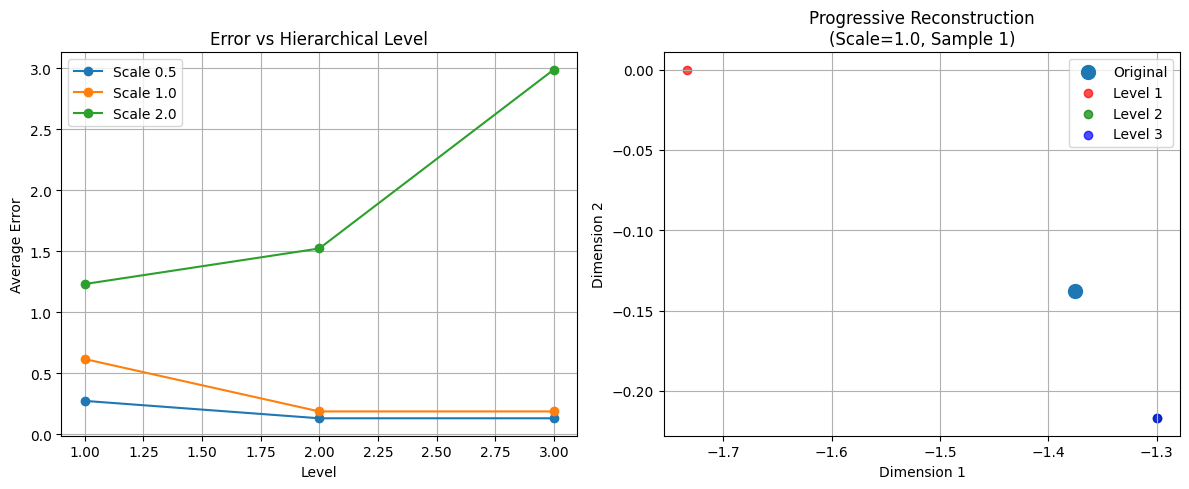

In [5]:
plt.figure(figsize=(12, 5))

# Plot error vs level for different scales
plt.subplot(121)
for scale in test_scales:
    scale_data = df[df['Scale'] == scale]
    avg_error = scale_data.groupby('Level')['Error'].mean()
    plt.plot(avg_error.index, avg_error.values, 'o-', 
             label=f'Scale {scale}')

plt.title('Error vs Hierarchical Level')
plt.xlabel('Level')
plt.ylabel('Average Error')
plt.legend()
plt.grid(True)

# Plot first two dimensions of reconstruction progress
plt.subplot(122)
scale_to_plot = 1.0  # middle scale
sample_to_plot = 1
sample_data = df[(df['Scale'] == scale_to_plot) & (df['Sample'] == sample_to_plot)]

# Original point
original = sample_data.iloc[0]['Original']
plt.scatter([original[0]], [original[1]], label='Original', s=100)

# Plot reconstructions at each level
colors = ['r', 'g', 'b']
for level in range(1, M+1):
    level_data = sample_data[sample_data['Level'] == level].iloc[0]
    recon = level_data['Reconstructed']
    plt.scatter([recon[0]], [recon[1]], 
                label=f'Level {level}',
                color=colors[level-1],
                alpha=0.7)

plt.title(f'Progressive Reconstruction\n(Scale={scale_to_plot}, Sample 1)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Analysis

The hierarchical nested lattice quantization demonstrates:
1. Progressive refinement of reconstruction quality with each level
2. Different rate-distortion trade-offs at different scales
3. Successive approximation of the original vector
4. Improved reconstruction quality with increasing number of levels

This approach is particularly useful when:
- Variable precision is needed
- Progressive transmission is desired
- Adaptive bit allocation is required